# Penentuan Jarak Terpendek atau Tercepat untuk Jalur Distribusi Logistik Menggunakan Dijkstra

Pada notebook ini akan dilakukan penentuan jarak terpendek dan tercepat menggunakan algoritma Dijkstra. Algoritma Dijkstra adalah salah satu algoritma yang sering digunakan untuk menentukan jalur dengan total *weight* terendah, *weigth* ini dapat berupa jarak, waktu, cost dan lain sebagainya.

Kasus yang diangkat berangkat dari tantangan distribusi logistik pangan, dalam hal ini distribusi pangan oleh Bulog (Badan Urusan Logistik). Bulog bertugas untuk memastikan ketahanan pangan dengan terlibat pada distribusi pangan domestik.<sup>[[1](https://repository.cips-indonesia.org/publications/338075/the-governments-role-in-the-indonesian-rice-supply-chain)]</sup> Selain penentuan stok pangan pada tiap daerah dengan tepat, dibutuhkan juga optimasi jalur terpendek atau tercepat dalam distribusi pangan antar daerahnya. Sehingga kasus pada notebook ini adalah penentuan jalur untuk jarak terdekat dan waktu tercepat untuk studi kasus gudang Bulog di Jawa Barat.


Tahapan yang akan dilakukan meliputi:
1. Pemetaan Gudang Bulog
2. Perhitungan jarak antar gudang Bulog berdasarkan koordinat
3. Mencari jalur jarak terdekat menggunakan Dijkstra
4. Mencari jalur waktu tercepat menggunakan Dijkstra
5. Pemetaan jalur terdekat dan tercepat

## Pemetaan Gudang Bulog

### Import library dan data

In [57]:
import pandas as pd # dataframe
import folium # untuk pemetaan
from geopy.distance import geodesic as GD # perhitungan jarak antar koordinat

Data mengandung 8 gudang Bulog di Jawa Barat beserta masing-masing koordinatnya.

In [58]:
bulog = pd.read_csv("data/bulog_coord.csv")

bulog

,Nama,Latitude,Longitude
0,Bekasi,-6.267213,107.118802
1,Karawang,-6.385801,107.407099
2,Bogor,-6.564365,106.734481
3,Purwakarta,-6.502901,107.461632
4,Cianjur,-6.777191,107.164300
5,Citeureup,-6.964082,107.622155
6,Bandung,-6.923185,107.700432
7,Sukabumi,-6.864819,106.974719


### Pemetaan Gudang Bulog di Jawa Barat

Selanjutnya dilakukan pemeteaan gudang Bulog di Jawa Barat untuk melihat persebaran lokasi menggunakan library `folium`.
`Folium` dapat melakukan pemetaan secara interaktif di Python. Referensi lebih lanjut mengenai [`folium`](https://python-visualization.github.io/folium/)

In [59]:
map_bulog = folium.Map(location=[bulog.Latitude.mean(), bulog.Longitude.mean()], 
                zoom_start=9, 
                control_scale=True)

for index, location_info in bulog.iterrows():
    folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["Nama"]).add_to(map_bulog)

map_bulog

Terlihat persebaran gudang Bulog di beberapa kabupaten di Jawa Barat. Gudang Bulog Bekasi dan Sukabumi cukup berjauhan dibandingkan gudang Bulog lainnya. Begitupun dengan Gudang Bulog Karawang, di mana Karawang adalah kabupaten dengan produksi beras kedua tertinggi di Jawa Barat setelah Indramayu.<sup>[[2](https://jabar.bps.go.id/indicator/53/52/1/produksi-padi-menurut-kabupaten-kota.html)]</sup> Sehingga dibutuhkan jalur paling optimal untuk distribusi beras dari daerah-daerah dengan produksi beras yang besar ke daerah-daerah dengan konsumsi beras yang besar.

## Perhitungan Jarak Antar Gudang Daerah

Data yang dimiliki memiliki titik koordinat, namun belum memiliki jarak antar koordinatnya, yang dimana jarak antar gudang ini yang akan digunakan sebagai pertimbangan jalur terdekat antar gudangnya.

Untuk perhitungan jarak, akan digunakan library `geopy` untuk menghitung jarak geodesic antar koordinat, yaitu jarak yang mempertimbangkan bentuk Globe dari Bumi.<sup>[[3](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)]</sup>

Contoh penerapan perhitungan jarak seperti di bawah ini

In [60]:
# Koordinat antar jarak
gudangBekasi = (-6.2672131395077555, 107.11880197831752)
gudangBogor = (-6.564365008337946, 106.73448114248629)

# Perhitungan jarak (satuan km)
jarak = GD(gudangBekasi, gudangBogor).km

print("Jarak antara Gudang Bekasi dan Bogor adalah %s km" % round(jarak, 2))

Jarak antara Gudang Bekasi dan Bogor adalah 53.74 km


Konsep yang sama digunakan untuk membuat dataframe baru, dimana kita menghitung jarak antar gudang kemudian menyimpannya di dataframe yang baru

In [61]:
# list kosong untuk kolom dataframe
titik1, titik2, jarak = [], [], []

for index, location_info in bulog.iterrows():
    for i in range(index + 1, len(bulog)):
        # Tambah nama
        titik1.append(location_info['Nama'])
        titik2.append(bulog.loc[i, 'Nama'])
        # assign coordinat
        coord1 = (location_info['Latitude'], location_info['Longitude'])
        coord2 = (bulog.loc[i, 'Latitude'], bulog.loc[i, 'Longitude'])
        # hitung jarak
        dist = GD(coord1,coord2).km
        # tambah jarak
        jarak.append(round(dist, 2))
        # save

# Membuat dataframe baru
df_jarak = pd.DataFrame({'titik1': titik1,
                        'titik2': titik2,
                        'jarak': jarak})

# Mengeluarkan titik dengan 5 jarak terjauh
bulog_jarak = df_jarak.sort_values(by="jarak", ascending=False).tail(-10)
bulog_jarak = bulog_jarak.reset_index(drop=True)

bulog_jarak

,titik1,titik2,jarak
0,Bekasi,Sukabumi,67.98
1,Karawang,Bandung,67.70
2,Purwakarta,Sukabumi,67.08
3,Cianjur,Bandung,61.42
4,Bekasi,Cianjur,56.62
5,Cianjur,Citeureup,54.66
6,Purwakarta,Citeureup,54.00
7,Bekasi,Bogor,53.74
8,Purwakarta,Bandung,53.45
9,Bogor,Cianjur,53.03


Telah terbentuk dataframe baru dimana mencakup informasi dari jarak untuk masing-masing gudang. Namun 10 observasi terjauh tidak dimasukkan ke dalam observasi dengan alasan efektivitas (distribusi antar gudang terjauh diharapkan melewati gudang diantaranya)

*Notes: Perhitungan jarak menggunakan **geodesic distance** kurang dapat merepresentasikan jarak jalanan sesungguhnya. Namun, kita tetap akan menggunakan **geodesic distance** untuk alasan akademi, nantinya kita akan menggunakan metriks yang lebih merepresentasikan realita, yaitu waktu*

## Jalur Terdekat Menggunakan Dijkstra

### Teori Graph

Graf (graph) adalah kumpulan dari *nodes* (simpul/sudut) dan *edges* (sisi) yang menggambarkan hubungan:
- *Nodes* adalah simpul/sudut yang merepresentasikan object.
- *Edges* menggambarkan koneksi antar objek/*nodes*

Sesuatu yang memiliki hubungan antar objek dapat direpresentasikan dengan graph, seperti jarak antar kota, jaringan telfon, hingga hubungan antar akun di sosial media.

Graf terbagi menjadi dua jenis, yaitu *unweighted graph* dan *weighted graph*:

![](assets/graph.png)

- *Unweighted Graph* 
*Unweighted Graph* adalah jenis graph yang merepresentasikan apakah antar *node* memiliki hubungan atau tidak.

- *Weighted Graph* 
*Weighted Graph* adalah pengembangan dari *unweighted graph* dimana setiap *edges* memiliki *weight* (beban). *Weight* ini sangat berguna untuk merepresentasikan hubungan antar objek yang memiliki nilai numerik, seperti hubungan jarak antar kota, ataupun dalam kasus kita adalah jarak antara gudang Bulog di Jawa Barat

Selanjutnya dataframe kita yang telah menggambarkan hubungan jarak antar Gudang dibuat menjadi teori graph menggunakan library `networkx`

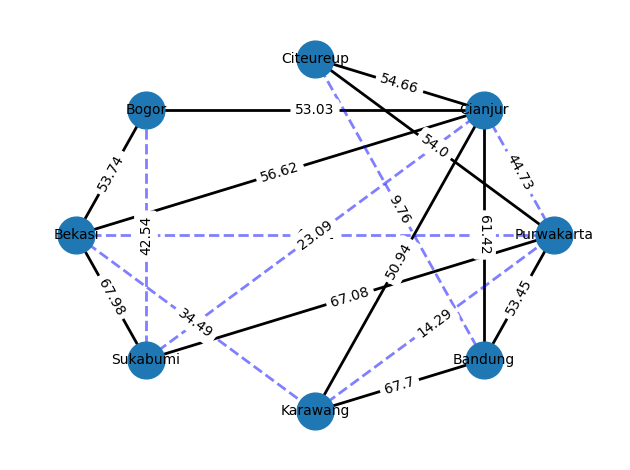

In [62]:
import matplotlib.pyplot as plt
import networkx as nx

# Rata-rata jarak 
mean = bulog_jarak['jarak'].mean()

# Membuat objek graph
G = nx.Graph()

# Assign setiap objek gudang ke dalam nodes
for ind in range(len(bulog_jarak)):
    row = bulog_jarak.iloc[ind].tolist()
    G.add_edge(row[0], row[1], weight=row[2])

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > mean]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= mean]

pos = nx.shell_layout(G) # Posisi nodes
# Menggambar node
nx.draw_networkx_nodes(G, pos, node_size=700)
# Menggambar edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=2)
# Custom edges berdasarkan jarak
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# Assign label pada tiap edges
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

Setiap gudang Bulog telah direpresentasikan ke dalam setiap *nodes* dengan *edges* yang merepresentasikan jarak. Seperti Gudang Bulog Bogor memiliki jarak 53,03 km ke Gudang Bulog Cianjur dan begitu sebaliknya. Kemudian tidak semua Gudang terhubung secara langsung ke gudang lainnya yang dimana harus melewati Gudang lain sebelum mengakses Gudang yang dituju. Salah satu contoh Gudang Sukabumi harus melewati Gudang Purwakarta untuk dapat terhubung ke Gudang Citeureup.

### Dijkstra

Algoritma Dijkstra adalah algoritma yang digunakan untuk mencari path dengan *weight* paling minimal antar *node*-nya.
Cara kerja dari Dijkstra adalah dengan membuat jalur ke satu simpul optimal (jarak terpendek) pada setiap langkah hingga menemui titik tujuan.

Secara umum, cara kerja dari dijsktra adalah sebagai berikut:
1. Tentukan titik mana yang akan menjadi node awal, lalu beri bobot jarak pada node pertama ke node terdekat satu per satu, Dijkstra akan melakukan pengembangan pencarian dari satu titik ke titik lain dan ke titik selanjutnya tahap demi tahap.
2. Beri nilai bobot (jarak) untuk setiap titik ke titik lainnya, lalu set nilai 0 pada node awal dan nilai tak hingga terhadap node lain (belum terisi) 2.
3. Set semua node yang belum dilalui  dan set node awal sebagai “Node keberangkatan”
4. Dari node keberangkatan, pertimbangkan node tetangga yang belum dilalui dan hitung jaraknya dari titik keberangkatan. Jika jarak ini lebih kecil dari jarak sebelumnya (yang telah terekam sebelumnya) hapus data lama, simpan ulang data jarak dengan jarak yang baru
5. Saat kita selesai mempertimbangkan setiap jarak terhadap node tetangga, tandai node yang telah dilalui sebagai “Node dilewati”. Node yang dilewati tidak akan pernah di cek kembali, jarak yang disimpan adalah jarak terakhir dan yang paling minimal bobotnya.
6. Set “Node belum dilewati” dengan jarak terkecil (dari node keberangkatan) sebagai “Node Keberangkatan” selanjutnya dan ulangi langkah 5.

Adapun ilustrasi dari Dijkstra adalah sebagai berikut:


![](assets/d1.PNG)

Dalam kasus ini kita ingin mencari jarak terdekat antara kota A dengan kota F, sehingga kita akan menentukan kota mana saja yang akan dilewati dengan jarak terdekat dari kota A dengan kota F

![](assets/d2.PNG)
![](assets/d3.PNG)
![](assets/d4.PNG)
![](assets/d5.PNG)
![](assets/d6.PNG)
![](assets/d7.PNG)

Dari hasil di atas, Algoritma Dijkstra menentukan jarak terdekat dari kota A ke kota F dapat melewati kota C kemudian D kemudian F.

### Penerapan Dijkstra

Setelah mengetahui cara kerja Dijkstra, selanjutnya kita akan menerapkan Algoritma Dijkstra untuk mengetahui jarak terdekat antara Gudang Bulog Karawang dengan Gudang Bulog Bogor.

Penerapan algoritma Dijkstra menggunakan method `dijkstra_path` dari library `networkx`.

In [73]:
list_path = nx.dijkstra_path(G, "Karawang", "Bogor")

list_path

['Karawang', 'Bekasi', 'Bogor']

Dari hasil Dijkstra Algoritma, distribusi dari Bulog Karawang ke Bogor harus melewati Bulog Bekasi. Sehingga ketika terdapat distribusi dari Karawang ke Bogor, dapat sekalian melakukan distribusi ke Bulog Bekasi juga.


Setelah mendapatkan jalur terdekat, yang ingin dilakukan adalah mengetahui *weight* atau jarak dari Gudang Karawang ke Gudang Bogor menggunakan `dijkstra_path_length`

In [76]:
jarak = nx.dijkstra_path_length(G, "Karawang", "Bogor")

jarak

88.23

Jarak dari Bulog Karawang ke Bulog Bogor (melewati Bulog Bekasi) diketahui sebesar 88,23 km.

Selanjutnya mari kita melakukan plotting alur Gudang tersebut menggunakan `folium`

In [ ]:
line = []
for location in list_path:
    rows = bulog[bulog["Nama"] == location].iloc[0]
    loc = (rows["Latitude"], rows["Longitude"])
    folium.Marker(loc, 
                popup=rows["Nama"],
                icon=folium.Icon(color="red")).add_to(map_bulog)
    line.append(loc)

folium.PolyLine(line, tooltip="Coast").add_to(map_bulog)

map_bulog

## Perhitungan Waktu Tercepat

Nilai *Edges* pada graf bukan hanya bisa direpresentasikan oleh jarak, tapi bisa juga dengan nilai lain seperti waktu, ataupun cost.<sup>[[4](https://www.researchgate.net/publication/299932101_Study_on_Optimization_of_Cold_Chain_Logistics_Distribution_Based_on_Improved_Particle_Swarm_Optimization_Algorithm)]</sup>  Nilai jarak yang kita hitung sebelumnya menggunakan *geodesic distance* dimana tidak mempertimbangkan jarak jalanan yang sebenarnya. Maka dari itu kita coba mengganti *weight* pada *edges* kita dengan nilai waktu tempuh antar gudangnya. Data ini didapatkan dari hasil waktu tempuh yang ditunjukkan oleh Google Maps ke masing-masing titik.

In [ ]:
bulog_waktu = pd.read_csv("data/bulog_time.csv")

bulog_waktu

,titik1,titik2,waktu
0,Bekasi,Karawang,41
1,Bekasi,Bogor,107
2,Karawang,Bogor,100
3,Karawang,Purwakarta,13
4,Karawang,Cianjur,179
5,Bogor,Purwakarta,168
6,Bogor,Cianjur,160
7,Bogor,Citeureup,222
8,Bogor,Bandung,228
9,Purwakarta,Cianjur,146


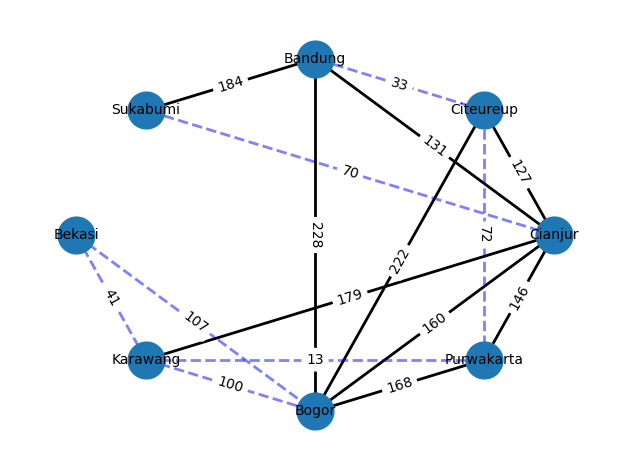

In [ ]:
# Rata-rata jarak 
mean = bulog_waktu['waktu'].mean()

# Membuat objek graph
G_waktu = nx.Graph()

# Assign setiap objek gudang ke dalam nodes
for ind in range(len(bulog_waktu)):
    row = bulog_waktu.iloc[ind].tolist()
    G_waktu.add_edge(row[0], row[1], weight=row[2])

elarge = [(u, v) for (u, v, d) in G_waktu.edges(data=True) if d["weight"] > mean]
esmall = [(u, v) for (u, v, d) in G_waktu.edges(data=True) if d["weight"] <= mean]

pos = nx.shell_layout(G_waktu) # Posisi nodes
# Menggambar node
nx.draw_networkx_nodes(G_waktu, pos, node_size=700)
# Menggambar edges
nx.draw_networkx_edges(G_waktu, pos, edgelist=elarge, width=2)
# Custom edges berdasarkan jarak
nx.draw_networkx_edges(
    G_waktu, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_labels(G_waktu, pos, font_size=10, font_family="sans-serif")

# Assign label pada tiap edges
edge_labels = nx.get_edge_attributes(G_waktu, "weight")
nx.draw_networkx_edge_labels(G_waktu, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

Dari hasil graph, terlihat bahwa tidak semua *nodes* terhubung ke *nodes* lainnya, seperti *nodes* Bekasi yang hanya terhubung ke *nodes* Karawang dan *Bogor*.

Selanjutnya akan dicari alur terdekat antara Gudang Bulog Bekasi ke Gudang Bulog Sukabumi

In [ ]:
list_path_waktu = nx.dijkstra_path(G_waktu, "Bekasi", "Sukabumi")

list_path_waktu

['Bekasi', 'Karawang', 'Purwakarta', 'Cianjur', 'Sukabumi']

In [ ]:
nx.dijkstra_path_length(G_waktu, "Bekasi", "Sukabumi")

270

Hasil alur Gudang Bulog Bekasi dan Sukabumi melewati Karawang, Purwakarta, dan Cianjur.

Selanjutnya akan dibandingkan dengan jarak terdekat antara Bekasi dan Sukabumi

In [81]:
nx.dijkstra_path(G, "Bekasi", "Sukabumi")

['Bekasi', 'Sukabumi']

In [82]:
nx.dijkstra_path_length(G, "Bekasi", "Sukabumi")

67.98

Dari hasil di atas, didapatkan bahwa secara jarak lebih dekat jika distribusi langsung dari Gudang Bekasi dan Sukabumi. Namun secara waktu, lebih cepat jika harus melalui jalur dan Gudang Karawang, Purwakarta, dan Cianjur sebelum mencapai Sukabumi.

Selanjutnya kita coba untuk visualisasi jalur tercepat antara Gudang Bekasi dan Gudang Sukabumi.

In [64]:
map_time = folium.Map(location=[bulog.Latitude.mean(), bulog.Longitude.mean()], 
                zoom_start=9, 
                control_scale=True)

for index, location_info in bulog.iterrows():
    folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["Nama"]).add_to(map_time)

line = []
for location in list_path_waktu:
    rows = bulog[bulog["Nama"] == location].iloc[0]
    loc = (rows["Latitude"], rows["Longitude"])
    folium.Marker(loc, 
                popup=rows["Nama"],
                icon=folium.Icon(color="red")).add_to(map_time)
    line.append(loc)

folium.PolyLine(line, tooltip="Coast").add_to(map_time)

map_time

Berhubung alur terdekat untuk mencapai Sukabumi harus melewati beberapa daerah, maka gudang-gudang yang dilewati sekalian mendapatkan distribusi ataupun gudang-gudang yang dilewati dapat menjadi gudang pusat distrbusi berhubung tempatnya yang strategis diantara gudang-gudang lainnya, seperti Cianjur dan Purwakarta

## Penutup

### Kesimpulan

Berdasarkan hasil notebook ini, didapatkan beberapa kesimpulan bahwa:

1. Dijkstra Algoritma dapat digunakan baik dalam mempertimbangkan jarak terdekat dan waktu tercepat. Jika *weight* pada *edges* berupa jarak maka yang dicari oleh Dijkstra adalah jarak terdekat, namun jika *weight* berupa waktu tempuh, maka yang didapatkan berupa waktu tercepat.
2. hasil dari jarak terdekat dan jalur tercepat tidak selalu sama. Seperti jalur dari Gudang Bekasi ke Sukabumi berdasakran jarak lebih dekat jika distribusi langsung antar gudangnya. Namun, jika menggunakan waktu lebih cepat untuk melalui jalur Bekasi -> Karawang -> Purwakarta -> Cianjur -> Sukabumi.

### Saran

*Weight* yang dipertimbangkan pada notebook ini hanya berupa jarak dan waktu tempuh. Kedepannya dapat dikembangkan untuk *weight* berupa *cost* gabungan dari waktu tempuh, biaya bensin, biaya tol dsb. untuk mendapatkan hasil yang lebih optimal dalam menekan biaya distribusi.

## Referensi

[1] [The Government’s Role in the Indonesian Rice Supply Chain](https://repository.cips-indonesia.org/publications/338075/the-governments-role-in-the-indonesian-rice-supply-chain)

[2] [Produksi Padi Jawa Barat Menurut Kabupaten/Kota oleh BPS](https://jabar.bps.go.id/indicator/53/52/1/produksi-padi-menurut-kabupaten-kota.html)

[3] [Geodesic Distance](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)

[4] [Study on Optimization of Cold Chain Logistics Distribution Based on Improved Particle Swarm Optimization Algorithm](https://www.researchgate.net/publication/299932101_Study_on_Optimization_of_Cold_Chain_Logistics_Distribution_Based_on_Improved_Particle_Swarm_Optimization_Algorithm)